# IMAGE CAPTIONING (EfficientNetB0 & Transformer)

- https://www.tensorflow.org/api_docs/python/tfm/nlp/models/TransformerDecoder
- https://keras.io/examples/vision/image_captioning


In [60]:
import sys
print(sys.executable)


/root/miniconda3/envs/tf-gpu/bin/python


In [61]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Dynamic memory growth diaktifkan.")
    except RuntimeError as e:
        print(e)


1. load pairs dataset
2. prepare caption & vectorizer
3. build dataset
4. build visual encoder
5. build transformer decoder
6. build wrapper(encoder + decoder)
7. loss masking
8. training
9. test (inference loop)

In [ ]:
# library import
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pickle
import re, string
import keras
import collections
from collections import Counter

import os, json, time, cv2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import 
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess
# from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Eval prediction caption
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO

In [ ]:
# HYPERPARAMS
D_MODEL = 512
NUM_HEADS=2
DFF= 2048
NUM_LAYERS=2
MAX_CAP_LEN = 20
VOCAB_SIZE=10000
BATCH_SIZE=64
LR=1e-4

In [64]:
# GPU cek
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [65]:
print(tf.__version__)

2.20.0


### 1. Load json COCO2017

In [66]:
json_path = "data/coco2017/annotations/annotations/captions_train2017_subset.json"

with open(json_path, "r") as f:
  data=json.load(f)

print(data["annotations"][0].keys())

images_df = pd.DataFrame(data['images'])
annotations_df = pd.DataFrame(data['annotations'])

# gabungkan berdasarkan image_id
merged_df = annotations_df.merge(images_df, left_on='image_id', right_on='id', suffixes=('_caption', '_image'))

# tampilkan kolom penting
df = merged_df[['image_id', 'file_name', 'caption']]
print(df.head())



dict_keys(['image_id', 'id', 'caption'])
   image_id         file_name  \
0    203564  000000203564.jpg   
1    322141  000000322141.jpg   
2     16977  000000016977.jpg   
3    106140  000000106140.jpg   
4    106140  000000106140.jpg   

                                             caption  
0  A bicycle replica with a clock as the front wh...  
1  A room with blue walls and a white sink and door.  
2  A car that seems to be parked illegally behind...  
3  A large passenger airplane flying through the ...  
4  There is a GOL plane taking off in a partly cl...  


In [67]:
import pandas as pd
pd.DataFrame(data["annotations"]).head()


,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


#### Load COCO pairs

In [ ]:
base_dir="./data/coco2017"

train_img_dir = os.path.join(base_dir, "images", "train2017_subset")
train_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_train2017_subset.json")

def load_coco_pairs(img_dir, ann_path):
  with open(ann_path, 'r') as f:
    ann=json.load(f)

  images ={img['id']: img['file_name'] for img in ann['images']}
  pairs=[]
  annots = ann['annotations']

  for item in annots:
    img_id = item['image_id']
    img_path = os.path.join(img_dir, images[img_id])
    caption = item['caption']

    if os.path.exists(img_path):
      # VALIDASI
      assert isinstance(img_path, str), f"img_path bukan string: {img_path}"
      assert isinstance(caption, str), f"caption bukan string: {caption}"
      pairs.append((img_path, caption))

  return pairs


In [69]:
base_dir="./data/coco2017"

# load all validation data
val_img_dir = os.path.join(base_dir, "images", "val2017", "val2017")
val_ann_path = os.path.join(base_dir, "annotations", "annotations", "captions_val2017.json")


In [70]:
# 1. load coco pairs
train_pairs = load_coco_pairs(train_img_dir, train_ann_path)
val_pairs = load_coco_pairs(val_img_dir, val_ann_path)

In [ ]:
counter = Counter([p[0] for p in train_pairs])
print(counter.most_common(5))


[('./data/coco2017/images/train2017_subset/000000336464.jpg', 7), ('./data/coco2017/images/train2017_subset/000000075663.jpg', 6), ('./data/coco2017/images/train2017_subset/000000411564.jpg', 6), ('./data/coco2017/images/train2017_subset/000000438258.jpg', 6), ('./data/coco2017/images/train2017_subset/000000027065.jpg', 6)]


In [72]:
print(train_pairs[:5])
print(type(train_pairs[0][0]), type(train_pairs[0][1]))


[('./data/coco2017/images/train2017_subset/000000203564.jpg', 'A bicycle replica with a clock as the front wheel.'), ('./data/coco2017/images/train2017_subset/000000322141.jpg', 'A room with blue walls and a white sink and door.'), ('./data/coco2017/images/train2017_subset/000000016977.jpg', 'A car that seems to be parked illegally behind a legally parked car'), ('./data/coco2017/images/train2017_subset/000000106140.jpg', 'A large passenger airplane flying through the air.'), ('./data/coco2017/images/train2017_subset/000000106140.jpg', 'There is a GOL plane taking off in a partly cloudy sky.')]
<class 'str'> <class 'str'>


### 2.preprocess caption & vectorizer
- vectorizer_data = vectorizer yg disave

In [73]:
def custom_standardization(input_string):
    strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    strip_chars = strip_chars.replace("<", "")
    strip_chars = strip_chars.replace(">", "")

    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


In [74]:
def build_text_vectorizer(pairs, max_length=20):
  captions =[f"<start> {cap} <end>" for _, cap in pairs]

  # 1. layer teks vectorizer(ubah dlm bentuk numerik)
  vectorizer = tf.keras.layers.TextVectorization(
      max_tokens = VOCAB_SIZE, # end & start
      output_sequence_length = max_length,
      standardize=custom_standardization,
      output_mode="int"
  )
  vectorizer.adapt(captions)

  vocab = vectorizer.get_vocabulary()
  print("vocab size: ", len(vocab))
  print("First token: ", vocab[:10])
  
  # index_lookup=dict(zip(range(len(vocab_final_list)), vocab_final_list))
  # save vocab (utk inference)
  with open('vectorizer_data.pkl', "wb") as f:
    pickle.dump({
        "vocab":vocab,
        "max_length": max_length,
        "max_vocab_size": VOCAB_SIZE
    }, f)

  return vectorizer

In [75]:
vectorizer=build_text_vectorizer(train_pairs)
print(vectorizer("a cat sitting on a mat"))

vocab size:  9521
First token:  ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with']
tf.Tensor(
[   2   59   15    6    2 1487    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)


In [76]:
# cek masking
vec = vectorizer("a cat sitting on a mat")
print(vec)
print(vec==0)

tf.Tensor(
[   2   59   15    6    2 1487    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(20,), dtype=int64)
tf.Tensor(
[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True], shape=(20,), dtype=bool)


In [77]:
img_paths = [p[0] for p in train_pairs]
print(img_paths[:3])

capt=[p[1] for p in train_pairs]
print(capt[:3])

['./data/coco2017/images/train2017_subset/000000203564.jpg', './data/coco2017/images/train2017_subset/000000322141.jpg', './data/coco2017/images/train2017_subset/000000016977.jpg']
['A bicycle replica with a clock as the front wheel.', 'A room with blue walls and a white sink and door.', 'A car that seems to be parked illegally behind a legally parked car']


In [78]:
def decode_tokens_to_text(token_ids, vectorizer_layer):

    vocab_list = vectorizer_layer.get_vocabulary()

    ids_to_words = np.vectorize(lambda idx: vocab_list[idx] if idx < len(vocab_list) else "[MISS]")

    words = ids_to_words(token_ids)

    filtered= [w for w in words if w != '']

    return " ".join(filtered)

In [79]:
# vocab
vocab = vectorizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))

sentence = "my dog play in backyard"
tokenized_sent = vectorizer([sentence])

print("sentence : ",sentence)
print("output token ID : ", tokenized_sent.numpy())

# konvert ID -> sentence lg
token_ids = tokenized_sent.numpy()[0] # Ambil array ID pertama dari batch
decoded = decode_tokens_to_text(token_ids, vectorizer)
print("returned text= ", decoded)

# decoded = decode_tokens_to_text(token)
# print("Output index to word: ",index_lookup[10])

sentence :  my dog play in backyard
output token ID :  [[7216   73 1231    8 3146    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
returned text=  my dog play in backyard


In [80]:
print(vectorizer('<start> a dog running <end>'))
print([vocab[i] for i in vectorizer('<start> a dog running <end>')])

tf.Tensor(
[  3   2  73 439   4   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(20,), dtype=int64)
['<start>', 'a', 'dog', 'running', '<end>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [81]:
# Debugging <start> dan <end> ada
def debug_vectorizer(vectorizer, sample_captions):

    vocab = vectorizer.get_vocabulary()
    print("=== Vocabulary Info ===")
    print("Vocab size:", len(vocab))
    print("First 20 tokens:", vocab[:20])

    # Cek apakah <start> dan <end> ada
    print("\nCheck special tokens in vocab:")
    print("<start> in vocab?", "<start>" in vocab)
    print("<end> in vocab?", "<end>" in vocab)

    # Tokenisasi beberapa caption contoh
    print("\n=== Tokenized samples ===")
    for cap in sample_captions:
        tokens = vectorizer([cap])
        print(f"Original: {cap}")
        print(f"Token IDs: {tokens.numpy()[0]}")  # ambil 1 batch
        # Reverse lookup untuk cek hasil token
        id_to_token = dict(zip(range(len(vocab)), vocab))
        token_words = [id_to_token[i] for i in tokens.numpy()[0] if i != 0]
        print(f"Decoded tokens: {token_words}\n")

# Contoh penggunaan
sample_captions = [
    "<start> a dog is running <end>",
    "<start> a cat is sleeping <end>"
]

debug_vectorizer(vectorizer, sample_captions)


=== Vocabulary Info ===
Vocab size: 9521
First 20 tokens: ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with', 'and', 'is', 'to', 'street', 'an', 'sitting', 'bathroom', 'next', 'white', 'man']

Check special tokens in vocab:
<start> in vocab? True
<end> in vocab? True

=== Tokenized samples ===
Original: <start> a dog is running <end>
Token IDs: [  3   2  73  11 439   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Decoded tokens: ['<start>', 'a', 'dog', 'is', 'running', '<end>']

Original: <start> a cat is sleeping <end>
Token IDs: [  3   2  59  11 512   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Decoded tokens: ['<start>', 'a', 'cat', 'is', 'sleeping', '<end>']



### 3. Build dataset

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess

In [ ]:
# data pipeline
def caption_to_tokens(caption, vectorizer,max_len = MAX_CAP_LEN):
    token = vectorizer(tf.expand_dims(caption, 0))[0]  # shape (seq_len,)
    # pad
    token = token[:max_len]  # truncate
    pad_len = max_len - tf.shape(token)[0]
    token = tf.pad(token, [[0, pad_len]])
    token = tf.cast(token, tf.int32)
    token.set_shape([max_len])  # set shape statis
    # token = tf.cast(token, tf.int32)
    return token
    
def preprocess_input(img_path, caption, vectorizer, max_len=MAX_CAP_LEN):
    # 1. img preprocess
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img_converted = efficient_preprocess(img)

    # 2. tokenize caption
    token = vectorizer(tf.expand_dims(caption, 0))[0]  # shape (seq_len,)
    # pad
    token = token[:max_len]  # truncate
    pad_len = max_len - tf.shape(token)[0]
    token = tf.pad(token, [[0, pad_len]])
    token = tf.cast(token, tf.int32)
    token.set_shape([max_len])  # set shape statis
    # token = tf.cast(token, tf.int32)
    dec_in=token[:-1]
    dec_out = token[1:]
    return img_converted, dec_in, dec_out

def generate_dataset(pairs, vectorizer, batch_size=BATCH_SIZE):
    img_paths = [p[0] for p in pairs]
    captions=[p[1] for p in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))

    @tf.function
    def map_function(ip, cap):
        img, dec_in, dec_out = preprocess_input(ip, cap, vectorizer)
        return (img, dec_in), dec_out
    
    dataset = dataset.map(
        map_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    # oom try
    dataset = dataset.shuffle(buffer_size=2048)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [84]:
x = caption_to_tokens("a man riding a horse", vectorizer)
x.shape


TensorShape([20])

In [85]:
vectorizer=build_text_vectorizer(train_pairs, max_length=20)

train_data = generate_dataset(train_pairs,vectorizer)
val_data = generate_dataset(val_pairs,vectorizer)

vocab size:  9521
First token:  ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with']


In [86]:
for (img_batch, dec_in_batch), dec_out_batch in train_data.take(1):
    print("img_batch : ", img_batch.shape)
    print("dtype img_batch : ", img_batch.dtype)
    print("dec_in batch shape : ", dec_in_batch.shape)
    print("dec_out batch shape : ", dec_out_batch.shape)
    
    print(f"Nilai min piksel dalam batch: {tf.reduce_min(img_batch).numpy()}")
    print(f"Nilai max piksel dalam batch: {tf.reduce_max(img_batch).numpy()}")

    

img_batch :  (32, 224, 224, 3)
dtype img_batch :  <dtype: 'float32'>
dec_in batch shape :  (32, 19)
dec_out batch shape :  (32, 19)
Nilai min piksel dalam batch: 0.0
Nilai max piksel dalam batch: 255.0


2025-12-11 12:07:06.736707: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [87]:
# test sampel caption
sample_text = train_pairs[0][1]
tok = vectorizer(sample_text)
print("caption: ", sample_text)
print("result token vectorizer: ", tok.numpy())
print("length token: ", len(tok))

caption:  A bicycle replica with a clock as the front wheel.
result token vectorizer:  [   2  137 3807    9    2  162  143    5   41  544    0    0    0    0
    0    0    0    0    0    0]
length token:  20


### 4. Visual Encoder : pretrain EfficientNetB0

In [88]:
def create_padding_mask(seq):
    return tf.cast(seq != 0, tf.bool)   # (batch, seq_len)

In [ ]:
caption_tokens = tf.constant([[1, 2, 3, 4, 0, 0]])  # shape (1,6)
seq_len = tf.shape(caption_tokens)[1]

padding_mask = create_padding_mask(caption_tokens)

print("Caption tokens:", caption_tokens.numpy())
print("Padding mask:\n", padding_mask.numpy())


Caption tokens: [[1 2 3 4 0 0]]
Padding mask:
 [[ True  True  True  True False False]]


In [ ]:
@keras.saving.register_keras_serializable()
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # key per head
        key_dim = embed_dim // num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim = key_dim, dropout=0.0
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2=layers.LayerNormalization()

        self.dense_1 = layers.Dense(embed_dim, activation='relu') # perlebar dim
        self.dense_2 = layers.Dense(embed_dim) # persempit kembali

    def call(self, inputs, training=None, mask=None):
        attn_out = self.attention_1(query=inputs, value=inputs, key=inputs, 
                                    attention_mask=None,
                                    training=training)
        skip_1 = self.layernorm_1(inputs + attn_out) # residual conn1 + norm
        dense_out1 = self.dense_1(skip_1) # ffn
        dense_out2 = self.dense_2(dense_out1)
        out_1 = self.layernorm_2(skip_1+dense_out2) # residual conn 2 + norm
        return out_1

    def get_config(self):
        config=super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads":self.num_heads,
        })
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
def build_visual_encoder_all(d_model=D_MODEL, dense_dim=256, num_heads=8):
    # 1. input layer
    inp = layers.Input(shape=(224,224,3), dtype=(tf.float32))
    
    base =EfficientNetB0(include_top=False, weights='imagenet') # none, h,w,c
    base.trainable=False # tdk include MLP model (hanya extract static)
    feat = base(inp) # shape(batch, Height, Weight, C)

    # 2. reshape & projeksi dense : flatten dimensi spasial -> sequence
    C =feat.shape[-1] # static
    # flatten spatial dim -> (B, H*W, C)
    seq = layers.Reshape((-1,C))(feat) # B, H*W, C
    # projection ke dim model
    proj = layers.Dense(d_model, name='proj_visual')(seq) #b,49,256
    
    # 3. encoder block (encoder layer + visual encoder)
    enc_output = TransformerEncoderBlock(
        embed_dim = d_model,
        dense_dim = dense_dim,
        num_heads = num_heads
    )(proj) # b, 49, 256
    # print(enc_output.shape)
    model=tf.keras.Model(inputs=inp, outputs=enc_output, name='complete_visual_encoder')
    return model

# complete_encoder_model = build_complete_visual_encoder()

### 5. Decoder
- caption - token - embedding
- positional embedding (posisi word & konteks)
- masked self attention (jgn lihat next word)
- cross attention (caption - img fitur)
- output = logit per token

In [94]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, max_seq_len, vocab_size, d_model, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=d_model
        )
        self.pos_emb = layers.Embedding(
            input_dim=max_seq_len, output_dim=d_model
        )
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embed_scale = tf.math.sqrt(tf.cast(d_model, tf.float32))

    def call(self, inputs):
        # input = batch, seq (32, 19)
        seq_len = tf.shape(inputs)[-1]  
        positions = tf.range(start=0, limit=seq_len, dtype=tf.int32)
        embedded_positions = self.pos_emb(positions)[tf.newaxis, ...] # seqlen,dmodel -> 1,seqlen, dmodel
        embedded_tokens = self.token_emb(inputs) * self.embed_scale
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
# DECODER
@keras.saving.register_keras_serializable()
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads=num_heads
        self.dff = dff
        self.rate = rate

        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible by num_heads")
        
        head_dim = d_model//num_heads
        # tf.print("MHA1 expected mask shape (B, 1, Q, K) =", 
        #  [tf.shape(x)[0], 1, tf.shape(x)[1], tf.shape(x)[1]])

        # masked self attention (hanya lihat token sblmny)
        self.mha1=layers.MultiHeadAttention(num_heads=num_heads, 
                                            key_dim=head_dim, dropout=rate)
        
        # tf.print("MHA2 expected mask shape (B, 1, Q, K) =",
        #  [tf.shape(x)[0], 1, tf.shape(x)[1], tf.shape(enc_output)[1]])
        self.mha2=layers.MultiHeadAttention(num_heads=num_heads, 
                                            key_dim=head_dim, dropout=rate)
        
        # ffn
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)    
        ])

        # layer norm
        self.layernorm1=layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3=layers.LayerNormalization(epsilon=1e-6)

        # dropout
        self.dropout1=layers.Dropout(rate)
        self.dropout2=layers.Dropout(rate)
        self.dropout3=layers.Dropout(rate)
        self.supports_masking=True

    
    def call(self,inputs, enc_output,training=False, self_mask=None, cross_mask=None, debug=False, return_attention=False):
        # 1. masked self-attention
        # caption embeding (masking spy decoder tdk lihat next token)
        attn1_out, attn1_scores = self.mha1(
            query=inputs, key=inputs, value=inputs,
            attention_mask=self_mask, #b, q, k
            training=training,
            return_attention_scores=True
        )
        attn1_out = self.dropout1(attn1_out, training=training)
        out1 = self.layernorm1(inputs + attn1_out)

        # 2. Cross-attention -- abaikan pad sj
        attn2_out, attn2_scores = self.mha2(
            query=out1,
            key=enc_output,
            value=enc_output,
            attention_mask=cross_mask, # enc padding mask (b,q,k encoder)
            training=training,
            return_attention_scores=True
        )
        attn2_out = self.dropout2(attn2_out, training=training)
        out2 = self.layernorm2(out1 + attn2_out)
       
        # 3. feed forward network
        ffn_output = self.ffn(out2)
        ffn_output=self.dropout3(ffn_output, training=training)
        out3=self.layernorm3(out2+ffn_output)
        # tf.print("attn1_out:", tf.shape(attn1_out))
        if debug:
            return {
                "attn1": out1,
                "attn2": out2,
                "ffn": out3,
                
                "attn1_scores": attn1_scores,
                "attn2_scores": attn2_scores
            }
        return out3
    
    def get_config(self):
        config= super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "rate":self.rate, #dropout rate
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
# full decoder
@keras.saving.register_keras_serializable()
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, 
                 max_seq_len, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        # token embedding (token ID -> vektor) -> positional embedding
        self.num_layers=num_layers
        self.num_heads=num_heads
        self.dff=dff

        self.d_model=d_model
        self.vocab_size=vocab_size
        self.max_seq_len=max_seq_len
        self.rate=rate

        # self.embedding = layers.Embedding(vocab_size, d_model)
        self.embedding = PositionalEmbedding(
            max_seq_len=max_seq_len,
            vocab_size=vocab_size,
            d_model=d_model
        )
        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]

        self.final_layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.final_dense = layers.Dense(vocab_size)
        self.dropout = layers.Dropout(rate)
        self.supports_masking=True

    def get_causal_mask(self, seq_len):
        # 1 where allowed (i >= j), 0 future
        i = tf.range(seq_len)[:, None]
        j = tf.range(seq_len)[None, :]
        mask = tf.cast(i >= j, dtype=tf.int32)  # (seq, seq)
        return tf.reshape(mask, (1, seq_len, seq_len))  # (1, seq, seq)

    def call(self, inputs, enc_output, training=False, mask=None, enc_mask=None, debug=False):        
        # ver positional encode (class)
        # x=input decoder (batch, seq len)
        # enc output = output enc (32,49,256)

        # awal = batch,seq
        x = self.embedding(inputs) # B,seqlen, d model
        x = self.dropout(x, training=training)

        seq_len = tf.shape(inputs)[1]
        causal_mask = tf.cast(self.get_causal_mask(seq_len), tf.bool)#1,s,s

        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], tf.bool) #batch,1,seq
            # dec_padding_for_min = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)    # (batch, 1, seq)
            # butuh (batch, seq, seq) -> create dec_padding_for_min tiled:
            dec_padding_full = tf.tile(padding_mask, [1, seq_len, 1])     # (batch, seq, seq)
            combined_mask = tf.logical_and(dec_padding_full, causal_mask)   #b,s,s
        else:
            combined_mask= causal_mask  

        enc_attention_mask = None
        if enc_mask is not None:
            # enc_mask: (batch, enc_len) True=tdk pad
            # MultiHeadAttention (batch, 1, 1, enc_len) boolean- broadcast(batch, num_heads, query_len, enc_len)
            enc_attention_mask = enc_mask[:, None, :]   # (B, 1, enc_len) --akan expand ke (B, S, enc_len)

        # self attention (padding mask & causal caption)
        # debug
        if debug:
            attention_weights={}
        else:
            attention_weights=None

        x_in = x
        # loop dgn decoder layers yg sama
        for i, dec_layer in enumerate(self.dec_layers):
            if debug:
                out = dec_layer(
                    x_in,
                    enc_output,
                    training=training,
                    self_mask=combined_mask,
                    cross_mask=enc_attention_mask,
                    debug=True,
                )
                # simpan per-layer
                attention_weights[f"decoder_layer_{i}"] = out
                x_in = out["ffn"]
            else:
                x_in = dec_layer(inputs=x_in, 
                            enc_output=enc_output, 
                            training=training, 
                            self_mask=combined_mask,
                            cross_mask=enc_attention_mask
                            )
            
        x_in= self.final_layernorm(x_in) # normalisasi
        logits = self.final_dense(x_in) # B, seq_len, vocab_size

        if debug:
            return logits, attention_weights
        return logits

    def get_config(self):
        config=super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads":self.num_heads,
            "dff":self.dff,
            "vocab_size": self.vocab_size,
            "max_seq_len": self.max_seq_len,
            "rate": self.rate,

            "embedding": keras.saving.serialize_keras_object(self.embedding),
            "dec_layers": [keras.saving.serialize_keras_object(l) for l in self.dec_layers]
        })
        return config
    @classmethod
    def from_config(cls, config):
        # return cls(**config)
        embedding = keras.saving.deserialize_keras_object(config.pop("embedding"))
        dec_layers = [keras.saving.deserialize_keras_object(l) for l in config.pop("dec_layers")]
        obj = cls(**config)
        obj.embedding = embedding
        obj.dec_layers = dec_layers
        return obj

### check decoder (updated)

In [97]:
batch = 2
dec_seq = 10
enc_seq = 49
d_model = 256
vocab = 1000

dummy_dec_in = tf.random.uniform((batch, dec_seq), maxval=vocab, dtype=tf.int32)
dummy_enc_out = tf.random.normal((batch, enc_seq, d_model))
dummy_mask = tf.concat([tf.ones((batch, 8), dtype=tf.int32), tf.zeros((batch, dec_seq-8), dtype=tf.int32)], axis=1)
dummy_mask_bool = tf.cast(dummy_mask, tf.bool)

decoder = TransformerDecoder(num_layers=2, 
                             d_model=d_model, 
                             num_heads=8, 
                             dff=512, 
                             vocab_size=vocab, max_seq_len=dec_seq)

logits = decoder(dummy_dec_in, dummy_enc_out, training=False,
                 mask=dummy_mask_bool, enc_mask=tf.ones((batch, enc_seq), dtype=tf.bool))
print("logits shape:", logits.shape)

# self mask ; batch, seqlen, seqlen
# cross mask ; batch, 1, enc seqlen

logits shape: (2, 10, 1000)


In [98]:
def create_padding_mask(seq):
    # seq: (batch, seq_len)
    mask = tf.not_equal(seq, 0)  # True (0) di pad
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch,1,1,seq_len)

In [99]:
dummy_dec_in = tf.constant([[5,6,7,8]])  # no PAD
dummy_enc_out = tf.random.normal((1, 10, 256))
dummy_mask = tf.constant([[True, True, True, True]])     # no pad
dummy_enc_mask = tf.ones((1, 10), dtype=tf.bool)

logits, attn = decoder(
    dummy_dec_in,
    dummy_enc_out,
    training=False,
    mask=dummy_mask,
    enc_mask=dummy_enc_mask,
    debug=True
)

print("ATTN1 SHAPE :", attn["decoder_layer_0"]["attn1_scores"].shape)
print("CAUSAL MASK :", decoder.get_causal_mask(4)[0].numpy())


ATTN1 SHAPE : (1, 8, 4, 4)
CAUSAL MASK : [[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]


In [100]:
# padding mask self attention
dummy_dec_in = tf.constant([[5, 6, 0, 0]])
dummy_mask = tf.constant([[True, True, False, False]])   # True = bukan pad

logits, attn = decoder(
    dummy_dec_in,
    dummy_enc_out,
    training=False,
    mask=dummy_mask,
    enc_mask=dummy_enc_mask,
    debug=True
)

mask = decoder.get_causal_mask(4).numpy() & \
       tf.tile(dummy_mask[:,None,:], [1,4,1]).numpy()

print(mask[0])



[[1 0 0 0]
 [1 1 0 0]
 [1 1 0 0]
 [1 1 0 0]]


In [101]:
seq1 = tf.constant([[5,6,0,0]])
mask1 = tf.constant([[True,True,False,False]])

seq2 = tf.constant([[5,6]])
mask2 = tf.constant([[True,True]])

# PAD CASE
logits1, _ = decoder(seq1, dummy_enc_out, training=False,
                     mask=mask1, enc_mask=dummy_enc_mask, debug=True)

# NO PAD CASE
logits2, _ = decoder(seq2, dummy_enc_out, training=False,
                     mask=mask2, enc_mask=dummy_enc_mask, debug=True)

print("Diff at token 0:", tf.reduce_sum(tf.abs(logits1[0,0] - logits2[0,0])))
print("Diff at token 1:", tf.reduce_sum(tf.abs(logits1[0,1] - logits2[0,1])))


Diff at token 0: tf.Tensor(0.00024218718, shape=(), dtype=float32)
Diff at token 1: tf.Tensor(0.00023345649, shape=(), dtype=float32)


In [102]:
import inspect
print(inspect.signature(decoder.call))


(inputs, enc_output, training=False, mask=None, enc_mask=None, debug=False)


### 6. Wrapper (encoder + decoder)

- simpan encoder(projected fitur)+ decoder
- simpan start & end token untuk test

In [103]:
import inspect
print(inspect.signature(TransformerDecoder.call))


(self, inputs, enc_output, training=False, mask=None, enc_mask=None, debug=False)


#### Wrapper

In [ ]:
# AUGMENTATION IMAGE
image_aug = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ],
    name="image_augmentation",
)

In [ ]:
@keras.saving.register_keras_serializable()
class CaptionTrainer(tf.keras.Model):
    def __init__(self, vocab_size, max_seq_len, d_model, num_heads, dff, num_layers, rate=0.1, num_captions_per_image=1, img_aug=None,**kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.rate = rate
        self.num_captions_per_image = num_captions_per_image
        self.img_aug=img_aug

        # def build_visual_encoder_all(d_model=D_MODEL, dense_dim=256, num_heads=8):
        self.encoder = build_visual_encoder_all(d_model=self.d_model)          # efficient net encoder
        self.decoder = TransformerDecoder(
                        num_layers=self.num_layers, 
                        d_model=self.d_model, 
                        num_heads=self.num_heads, 
                        dff=self.dff, 
                        vocab_size=self.vocab_size, 
                        max_seq_len=self.max_seq_len, 
                        rate=rate) 
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction=None
        )
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
    
    
    def call(self, inputs, training=False):
        # inputs: tuple (img, caption_inp)
        imgs, captions_inp = inputs # dec in

        enc_out = self.encoder(imgs, training=training)
        dec_pad_mask = create_padding_mask(captions_inp) #batch,seqlen
        logits = self.decoder(inputs=captions_inp, 
                              enc_output=enc_out, 
                              mask=dec_pad_mask,
                              enc_mask=None,
                              training=training)
        return logits

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "max_seq_len": self.max_seq_len,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "num_layers": self.num_layers,
            "rate": self.rate,
            "num_captions_per_image": self.num_captions_per_image,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss_fn(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        y_true = tf.cast(y_true, tf.int32)

        pred_ids = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        matches = tf.equal(y_true, pred_ids)

        matches = tf.logical_and(tf.cast(mask, tf.bool), matches)
        matches = tf.cast(matches, tf.float32)
        mask = tf.cast(mask, tf.float32)

        return tf.math.divide_no_nan(tf.reduce_sum(matches), tf.reduce_sum(mask))
    

    def compute_loss_and_acc(self, img_embed, caption_inp, caption_true, training):
        # loss_mask = tf.cast(tf.not_equal(caption_true, 0), tf.float32)
        # seq_len = tf.shape(caption_inp)[1]

        dec_pad_mask = create_padding_mask(caption_inp)
        loss_mask = tf.cast(dec_pad_mask, tf.float32)
        logits = self.decoder(inputs=caption_inp, 
                              enc_output=img_embed, 
                              mask=dec_pad_mask,
                              enc_mask=None,
                              training=training)
        loss = self.calculate_loss(caption_true, logits, loss_mask) 
        acc  = self.calculate_accuracy(caption_true, logits, loss_mask)
        return loss, acc


    def train_step(self, data):
        (batch_img, dec_in_batch), dec_true = data
        train_vars = self.trainable_variables

        with tf.GradientTape() as tape:
            enc_out = self.encoder(batch_img, training=False) # b,49,dim model
            loss, acc = self.compute_loss_and_acc(
                enc_out, 
                dec_in_batch, # Input Decoder
                dec_true,  # Target Label (Ground Truth)
                training=True
            )

        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }

    def test_step(self, data):
        # (batch_img, dec_in_batch), dec_out_batch = data
        (batch_img, dec_in_batch), dec_true = data

        # 1. Encode image/img embedding -- (frozen)
        enc_out = self.encoder(batch_img, training=False) 
        loss, acc = self.compute_loss_and_acc(
            enc_out, 
            dec_in_batch, # Input Decoder
            dec_true,  # Target Label (Ground Truth)
            training=False
        )

        # Update the trackers
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.acc_tracker.result()
        }
    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]


In [106]:
def create_padding_mask(seq):
    return tf.cast(seq != 0, tf.bool)   # (batch, seq_len)


In [ ]:
for (img_batch, dec_in_batch), dec_out_batch in train_data.take(1):
    print("Image batch: ", img_batch.shape)
    print("decoder INPUT(enc output): ", dec_in_batch.shape)
    print("decoder output batch : ", dec_out_batch.shape)

    # 1. VISUAL ENC
    visual_encoder = build_visual_encoder_all(d_model=D_MODEL, 
                                              dense_dim=256, 
                                              num_heads=4)
    encoder_output_test = visual_encoder(img_batch)
    print(f"Encoder Output Shape (Input Decoder Key/Value): {encoder_output_test.shape}")
    # (B, 49, D_MODEL) = (32, 49, 256)
    
    # 2. DECODER
    sample_decoder = TransformerDecoder(
        num_layers=NUM_LAYERS, 
        d_model=D_MODEL, 
        num_heads=NUM_HEADS, 
        dff=DFF, 
        vocab_size=VOCAB_SIZE, 
        max_seq_len=MAX_CAP_LEN
    )

    # 3. PADDING MASK
    # decoder padding mask: (batch, seq_len)
    dec_pad_mask = create_padding_mask(dec_in_batch)
    print("dec pad mask : ", dec_pad_mask.shape)

    # 4. FOWARD PASS DECODER
    decoder_logits = sample_decoder(
        inputs=dec_in_batch,
        enc_output=encoder_output_test,
        mask=dec_pad_mask,   # causal sdh didefine dlm transformerdecoder
        enc_mask=None,
        training=False
    )

    print("Decoder Input:", dec_in_batch.shape)
    print("Encoder Output:", encoder_output_test.shape)
    print("Decoder Logits:", decoder_logits.shape)

    # logits shape ideal: (B, T, vocab_size)
    print(f"Decoder Logits Shape (Output Final): {decoder_logits.shape}")
    print("Dtype decoder logits:", decoder_logits.dtype)
    break

Image batch:  (32, 224, 224, 3)
decoder INPUT(enc output):  (32, 19)
decoder output batch :  (32, 19)
Encoder Output Shape (Input Decoder Key/Value): (32, 49, 256)
dec pad mask :  (32, 19)
Decoder Input: (32, 19)
Encoder Output: (32, 49, 256)
Decoder Logits: (32, 19, 10000)
Decoder Logits Shape (Output Final): (32, 19, 10000)
Dtype decoder logits: <dtype: 'float32'>


### 7. Summary

In [108]:
D_MODEL = 512
EMBED_DIM = 512
NUM_HEADS=2
DFF= 2048 # =ff dim = 4*512
NUM_LAYERS=2
MAX_CAP_LEN = 20
VOCAB_SIZE=10000
BATCH_SIZE=64
LR=1e-4 #standarny

# cnn_model = build_visual_encoder_all()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=DFF, num_heads=1)
decoder = TransformerDecoder(num_layers=NUM_LAYERS, 
                             d_model=D_MODEL, 
                             num_heads=NUM_HEADS, 
                             dff=DFF, 
                             vocab_size=VOCAB_SIZE, 
                             max_seq_len=MAX_CAP_LEN)

# vocab_size, max_seq_len, d_model, num_heads, dff, num_layers, rate=0.1, num_captions_per_image=1
caption_model = CaptionTrainer(
    vocab_size=VOCAB_SIZE,
    max_seq_len=MAX_CAP_LEN,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    num_layers=NUM_LAYERS,
    rate=0.3,
    num_captions_per_image=1,
    img_aug=image_aug
)


In [109]:
image_shape = (None, 224, 224, 3) # (Batch_size, H, W, C)
caption_input_shape = (None, MAX_CAP_LEN - 1) # (Batch_size, Seq_Len_Input)

caption_model.build(input_shape=[image_shape, caption_input_shape])

for ((img_batch, dec_in_batch), dec_out_batch) in train_data.take(1):
    _ = caption_model((img_batch, dec_in_batch)) 


caption_model.summary()


/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'caption_trainer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "caption_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_augmentation (Sequential) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ complete_visual_encoder         │ (None, 49, 512)        │     6,283,427 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_4           │ ?                      │    18,669,328 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,952,755 (95.19 MB)

 Trainable params: 20,903,184 (79.74 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### check 

In [110]:
import inspect
print(inspect.signature(caption_model.call))


(inputs, training=False)


### 8. TRAINING

https://arxiv.org/pdf/1706.03762

In [112]:
saving_path="./checkpoints"

print(os.path.exists(saving_path))

True


In [ ]:
# 1. warmup awal train
@keras.saving.register_keras_serializable()
class WarmUpLinear(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, final_lr, decay_type="linear"):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.final_lr = final_lr
        self.decay_type = decay_type

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        # Warmup
        warmup_lr = self.initial_lr * (step / self.warmup_steps)
        # Linear decay
        linear_lr = tf.linspace(self.initial_lr, self.final_lr, 10000)[tf.cast(step, tf.int32) % 10000]
        # choose based on step
        return tf.where(step < self.warmup_steps, warmup_lr, linear_lr)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "warmup_steps": self.warmup_steps,
            "final_lr": self.final_lr,
            "decay_type": self.decay_type,
        }

In [114]:
EPOCHS=30
INITIAL_LR = 1e-4 # Untuk epoch 1-5 (cm train transformer)
lr_schedule=WarmUpLinear(
    initial_lr=1e-4,
    warmup_steps=1000,
    final_lr=1e-5
)
# compile & callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, #10
    restore_best_weights=False
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(saving_path, "model_epoch{epoch:02d}.keras"),
    # filepath = os.path.join(saving_path, "model_epoch{epoch:02d}.weights.h5"),
    monitor = 'val_loss',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)


In [ ]:
# 2. COMPILE

# caption_model.compile(
#     optimizer=tf.keras.optimizers.Adam(lr_schedule)
# )
caption_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
    loss= caption_model.loss_fn,
    metrics=['accuracy']
)

In [ ]:
import tensorflow as tf

# cek TensorFlow - CUDA
print(f"TensorFlow built with CUDA support: {tf.test.is_built_with_cuda()}")

physical_devices = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(physical_devices)}")
if len(physical_devices) > 0:
    print(f"GPU Device Found: {physical_devices[0].name}")
else:
    print("No GPU devices found, using CPU or integrated graphics.")


TensorFlow built with CUDA support: True
Num GPUs Available: 0
No GPU devices found, using CPU or integrated graphics.


In [ ]:
# 3. TRAIN
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
# tf.config.run_functions_eagerly(True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
tf.get_logger().setLevel('ERROR')        # logging TF ke ERROR saja


with tf.device('/GPU:0'):
    history = caption_model.fit(
        train_data,
        validation_data=val_data,
        epochs=30,
        callbacks=[early_stopping, checkpoint_callback]
    )

Epoch 1/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1751 - loss: 6.4542
Epoch 1: saving model to ./checkpoints/model_epoch01.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 266s 162ms/step - accuracy: 0.2695 - loss: 4.8927 - val_accuracy: 0.3201 - val_loss: 4.2004
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3693 - loss: 3.5458
Epoch 2: saving model to ./checkpoints/model_epoch02.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 256s 163ms/step - accuracy: 0.3881 - loss: 3.3199 - val_accuracy: 0.3576 - val_loss: 3.7209
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4044 - loss: 3.1505
Epoch 3: saving model to ./checkpoints/model_epoch03.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 256s 163ms/step - accuracy: 0.4165 - loss: 3.0116 - val_accuracy: 0.3735 - val_loss: 3.5491
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4233 - loss: 2.9425
Epoch 4: saving model to ./checkpoints/model_epoch04.keras
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 257s

### PLOTTING - updated (history)

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


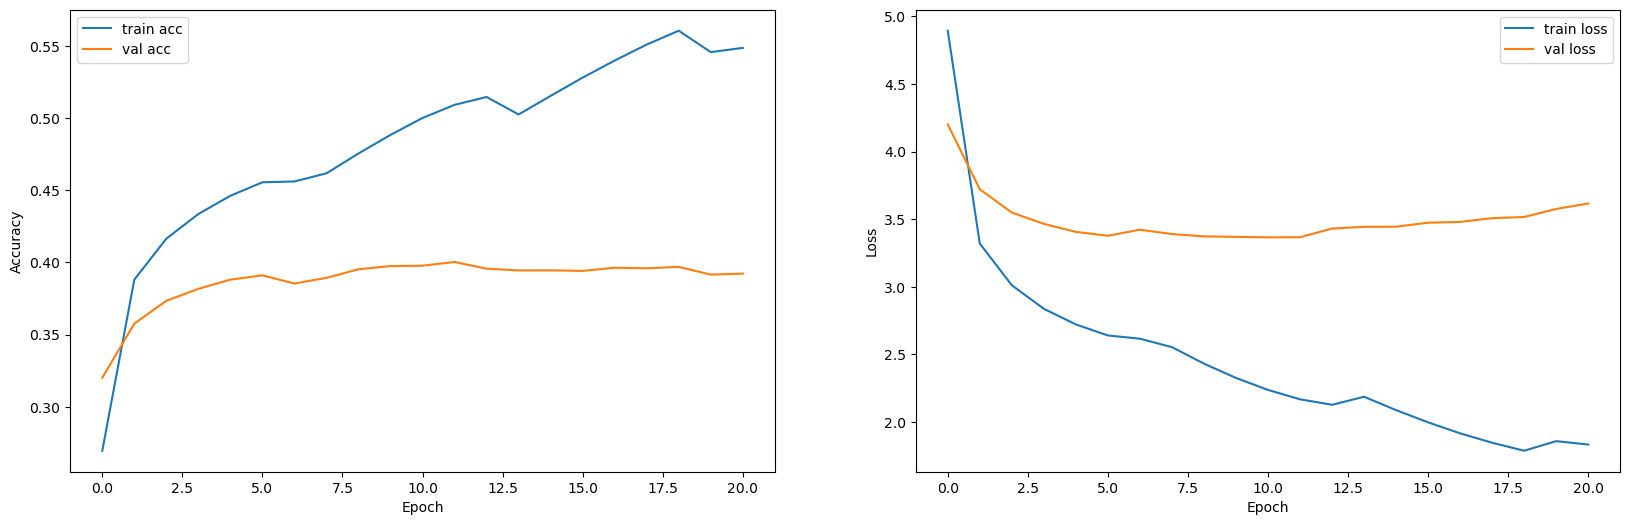

In [ ]:
# 5 epoch newest extraction
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 9. Load Trained Model

In [ ]:
# 1. load model
model_path="checkpoints/model_epoch21_55p.keras"
print(os.path.exists(model_path))

last_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        # Kelas Model Utama
        "CaptionTrainer": CaptionTrainer,
        # Sub-kelas Kustom (Layers/Models)
        "TransformerDecoder": TransformerDecoder,
        "DecoderLayer": DecoderLayer,
        "TransformerEncoderBlock": TransformerEncoderBlock, # <-- Tambahkan ini
        # helper (jk perlu)
        "build_visual_encoder_all": build_visual_encoder_all, 
        "WarmUpLinear": WarmUpLinear,
    }
)

last_model.summary()

True


Model: "caption_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ complete_visual_encoder         │ (None, 49, 512)        │     6,283,427 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_5           │ ?                      │    18,669,328 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,759,124 (254.67 MB)

 Trainable params: 20,903,184 (79.74 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 41,806,369 (159.48 MB)

In [ ]:
print("Loaded model : ", last_model)


Loaded model :  <CaptionTrainer name=caption_trainer, built=True>


### 10. inference/test model

In [120]:
vocab = vectorizer.get_vocabulary()
print(len(vocab))

index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = MAX_CAP_LEN- 1
# valid_images = val_img_paths
print(index_lookup)

9521
{0: '', 1: '[UNK]', 2: 'a', 3: '<start>', 4: '<end>', 5: 'the', 6: 'on', 7: 'of', 8: 'in', 9: 'with', 10: 'and', 11: 'is', 12: 'to', 13: 'street', 14: 'an', 15: 'sitting', 16: 'bathroom', 17: 'next', 18: 'white', 19: 'man', 20: 'two', 21: 'train', 22: 'at', 23: 'toilet', 24: 'standing', 25: 'are', 26: 'people', 27: 'sign', 28: 'bus', 29: 'kitchen', 30: 'parked', 31: 'that', 32: 'large', 33: 'it', 34: 'motorcycle', 35: 'small', 36: 'red', 37: 'sink', 38: 'down', 39: 'near', 40: 'bench', 41: 'front', 42: 'woman', 43: 'some', 44: 'giraffe', 45: 'by', 46: 'black', 47: 'city', 48: 'road', 49: 'building', 50: 'blue', 51: 'up', 52: 'top', 53: 'has', 54: 'side', 55: 'green', 56: 'riding', 57: 'group', 58: 'car', 59: 'cat', 60: 'field', 61: 'stop', 62: 'sheep', 63: 'person', 64: 'water', 65: 'bird', 66: 'traffic', 67: 'airplane', 68: 'there', 69: 'fire', 70: 'walking', 71: 'flying', 72: 'light', 73: 'dog', 74: 'plane', 75: 'hydrant', 76: 'room', 77: 'yellow', 78: 'grass', 79: 'over', 80: '

In [121]:
vectorizer=build_text_vectorizer(train_pairs, max_length=20)

vocab size:  9521
First token:  ['', '[UNK]', 'a', '<start>', '<end>', 'the', 'on', 'of', 'in', 'with']


In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img_converted = efficient_preprocess(img)
    return img_converted


def generate_caption_keras_style(caption_model, vectorizer, index_lookup,image_path, max_len=MAX_CAP_LEN-1, show_img=True):
    img = decode_and_resize(image_path)
    if show_img:
        img_show = img.numpy().clip(0,255).astype("uint8")
        plt.imshow(img_show)
        plt.axis("off")
        plt.show()

    # 1. pass image -> cnn
    img_batch = tf.expand_dims(img, axis=0)           # (1, H, W, 3)
    enc_output = caption_model.encoder(img_batch, training=False) # 1, seqlen, dmodel

    start_id=3
    end_id=4
    decoded_ids = [start_id]
    decoded_sentence = "<start>"
    for pos in range(max_len):
        # 2. Tokenisasi caption sementara
        tokenized = tf.expand_dims(decoded_ids, axis=0)  # (1, seq)
        mask = (tokenized != 0)
        # tokenized = vectorizer([decoded_sentence])  # (1, seq_len)
        # tokenized = tokenized[:, :-1]                 # buang [END]

        # dec_mask =  tf.cast(tokenized != 0, tf.bool) # (1, seq_len)
        predictions = caption_model.decoder(
            tokenized,
            enc_output, 
            mask=mask,
            training=False,
        )
        next_id = tf.argmax(predictions[0, -1]).numpy()
        # predictions shape = (1, seq_len, vocab)
        # token terakhir berada di posisi: tokenized_length - 1
        # last_pos = tokenized.shape[1] - 1
        # logits = predictions[0, last_pos, :].numpy()

        # 3. Greedy sampling (keras)
        # stop jika <end>
        if next_id == end_id:
            break

        decoded_ids.append(next_id)

    decoded_sentence = " ".join(index_lookup[i] for i in decoded_ids[1:])
    print("Predicted Caption: ", decoded_sentence)
    return decoded_sentence


In [126]:
from collections import Counter

counter = Counter([cap for _, cap in train_pairs])
print(counter.most_common(5))


[('A large long train on a steel track.', 25), ('a public transit bus on a city street', 21), ('A large jetliner sitting on top of an airport tarmac.', 9), ('A white toilet sitting next to a bathroom sink.', 8), ('A man riding on the back of a motorcycle down a street.', 8)]


In [127]:
path1 = train_pairs[25][0]
path2 = train_pairs[1][0]
img1 = decode_and_resize(path1)
img2 = decode_and_resize(path2)

e1 = caption_model.encoder(tf.expand_dims(img1,0), training=False).numpy()
e2 = caption_model.encoder(tf.expand_dims(img2,0), training=False).numpy()

print("L2 diff:", np.linalg.norm(e1 - e2))


L2 diff: 208.15807


In [128]:
img_capt=train_pairs[280][1]
print(img_capt)

A city street with people walking and vehicles on the road.


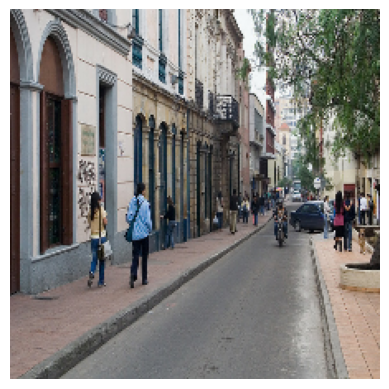

/root/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Predicted Caption:  a city street with people walking down the sidewalk          


'a city street with people walking down the sidewalk          '

In [129]:
img_path=train_pairs[280][0]
# print(img_path)
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

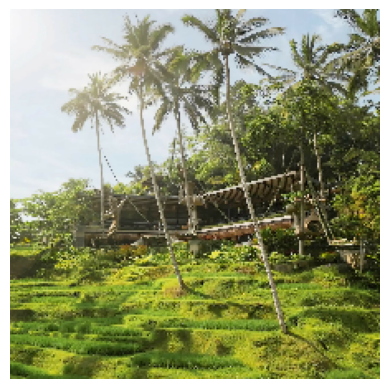

Predicted Caption:  and a tree in a field with trees in the background       and trees


'and a tree in a field with trees in the background       and trees'

In [133]:
# other image
img_path = 'scenery.jpg'
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

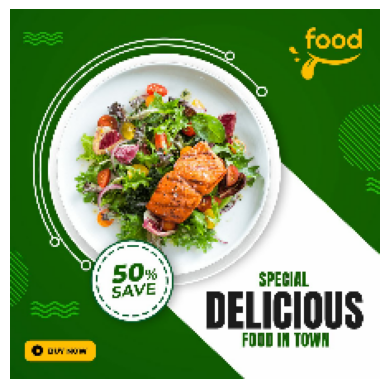

Predicted Caption:  a dish with a plate of food            


'a dish with a plate of food            '

In [134]:
# poster type
img_path = 'poster.jpg'
generate_caption_keras_style(last_model, vectorizer=vectorizer, index_lookup=index_lookup,
                             image_path=img_path)

## EVAL METRICS (pycocotools)

In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO

- https://github.com/salaniz/pycocoevalcap

In [136]:
print(type(val_pairs))
print(val_pairs[0][1])

<class 'list'>
A black Honda motorcycle parked in front of a garage.


In [ ]:
# 1. val path list
def get_val_path(val_pairs):
    val_img_paths=[]
    for pair in val_pairs:
        img_path = pair[0]
        val_img_paths.append(img_path)
    return list(val_img_paths)

# 2. list predict utk eval
def collect_predictions_eval(val_pairs, last_model, vectorizer, index_lookup, display_limit=20):
    results={}
    print(f"Predict for {len(val_pairs)} images...")
    for i, (img_path, img_id, _) in enumerate(val_pairs):
        caption = generate_caption_keras_style(
            last_model,
            vectorizer=vectorizer,
            index_lookup=index_lookup,
            image_path=img_path
        )
        results[img_id]=caption
        if i%50 ==0 and i>0:
            print(f"Finish predict {i} image")
    print("done collect prediction")
    return results

# data predict -> json
def coco_to_json(prediction_dict):
    coco_format=[]
    for i, (img_id, cap) in enumerate(prediction_dict.items()):
        coco_format.append({
            'image_id':img_id,
            'caption':cap,
            'id':i
        })
    return coco_format

def reference_json(val_pairs):
    # info, images, annotations
    annotations = []
    images=[]
    ann_id=1
    for img_path, img_id, caps in val_pairs:
        images.append({"image_id":img_id})

        for cap in caps:
            annotations.append({
                'image_id': img_id,
                'caption': cap,
                'id': ann_id # ID unik global
            })
            ann_id+=1
    return {
        "info": {"description": "COCO Reference File"},
        "images": images,
        "annotations": annotations
    }



In [139]:
def load_coco_eval(img_dir, ann_path):
    with open(ann_path, 'r') as f:
        ann = json.load(f)

    images = {img["id"]: img["file_name"] for img in ann["images"]}

    # kumpulkan caption per image_id
    ref_map = {}
    for item in ann["annotations"]:
        img_id = item["image_id"]
        caption = item["caption"]

        if img_id not in ref_map:
            ref_map[img_id] = []
        ref_map[img_id].append(caption)

    #  pairs =(img_path, [list_of_5_captions])
    pairs = []
    for img_id, caps in ref_map.items():
        img_path = os.path.join(img_dir, images[img_id])

        if os.path.exists(img_path):
            pairs.append((img_path, img_id, caps))

    return pairs

# 1. load coco eval pairs(5 capt)
eval_pairs = load_coco_eval(val_img_dir, val_ann_path)
print(eval_pairs[:2])

[('./data/coco2017/images/val2017/val2017/000000179765.jpg', 179765, ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']), ('./data/coco2017/images/val2017/val2017/000000190236.jpg', 190236, ['An office cubicle with four different types of computers.', 'The home office space seems to be very cluttered.', 'an office with desk computer and chair and laptop.', 'Office setting with a lot of computer screens.', 'A desk and chair in an office cubicle.'])]


In [140]:
def map_id_to_references(val_pairs):
    ref_map = {}
    for img_path, img_id, caps in val_pairs:
        ref_map[img_id] = caps
    return ref_map

subset_pairs_eval=eval_pairs[:1000]
# 2. petakan id => ref capt
# path, id, [caps]
# list fererence sesuai img_ids
reference_map = map_id_to_references(subset_pairs_eval)

In [ ]:
prediction_results_dict = collect_predictions_eval(
    subset_pairs_eval, 
    last_model, 
    vectorizer, 
    index_lookup
)

#### output prediction_results_dict (sample)

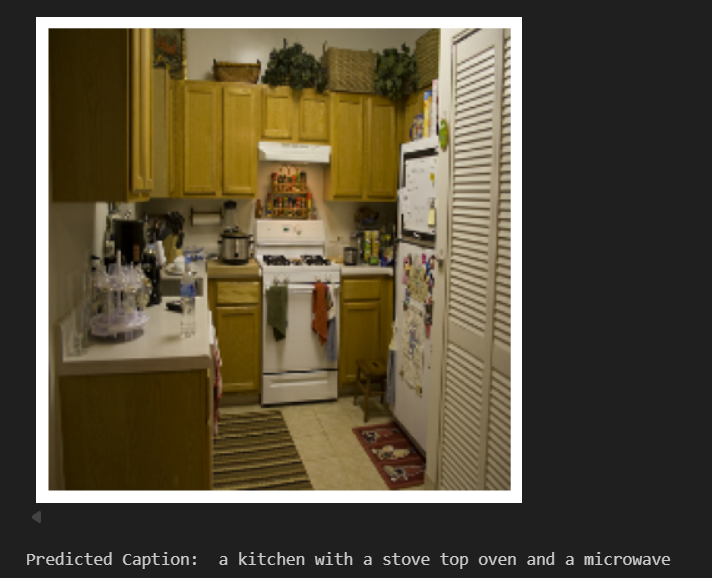
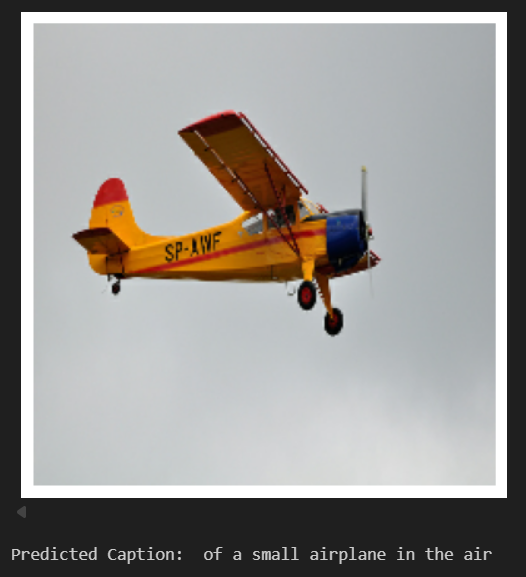
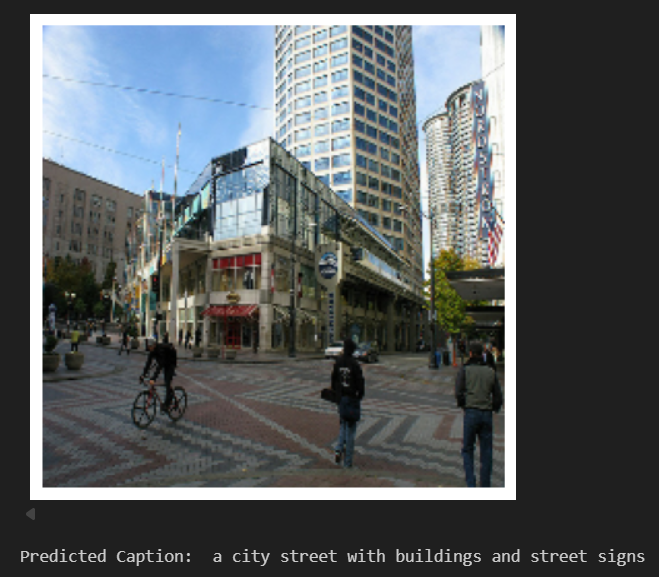
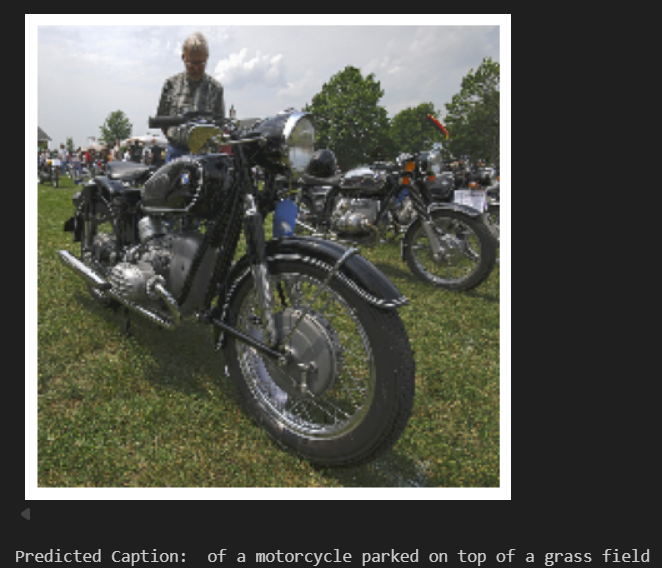
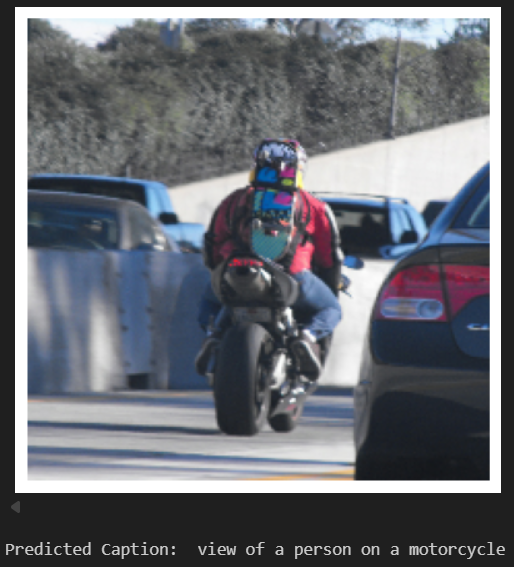
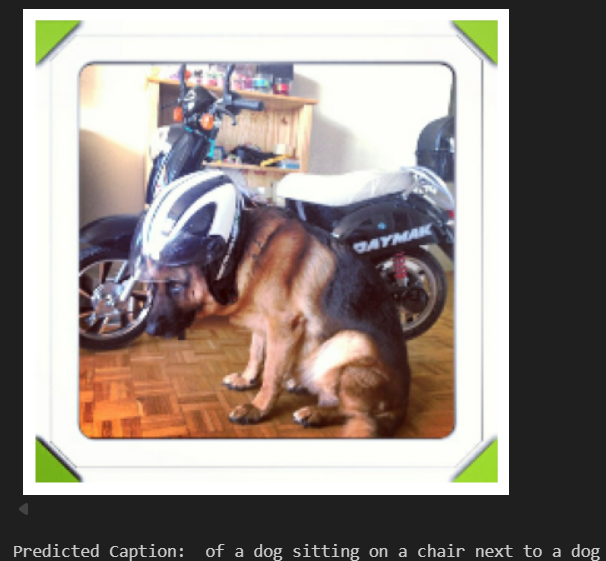

### Score

In [ ]:
print(list(prediction_results_dict.keys()))
print(list(prediction_results_dict.values()))

[179765, 190236, 331352, 517069, 182417, 46378, 93437, 172330, 472678, 314251, 223747, 109976, 12667, 482917, 534605, 289393, 561256, 338325, 65485, 226662, 11511, 221754, 249025, 255965, 51598, 445846, 192871, 365642, 393569, 116479, 63740, 570736, 492937, 117425, 159977, 232538, 177934, 96549, 469192, 44652, 210502, 298396, 187513, 552883, 228214, 453634, 201775, 391375, 557501, 435880, 555050, 466085, 442009, 127987, 368335, 423798, 140420, 204186, 40471, 10363, 173008, 452793, 456865, 504711, 288584, 551304, 276284, 103548, 226408, 558073, 102411, 48924, 230008, 181666, 543047, 565391, 485802, 86220, 412894, 99054, 26564, 62025, 489091, 155154, 71711, 152771, 437392, 571804, 78404, 308631, 423971, 304560, 221708, 26204, 85576, 153217, 270066, 348708, 224051, 163746, 382122, 571857, 209747, 575205, 17379, 55002, 202228, 194832, 147518, 3661, 147740, 243204, 368900, 214192, 134096, 441586, 425221, 163155, 216497, 515266, 360564, 90631, 427338, 58705, 360943, 302760, 252219, 313182, 9

In [ ]:
for k,v in prediction_results_dict.items():
    print("Pred: ", v)
    print("Refs: ", reference_map[k])
    break

Pred:  motorcycle parked on the grass near a tree           
Refs:  ['A black Honda motorcycle parked in front of a garage.', 'A Honda motorcycle parked in a grass driveway', 'A black Honda motorcycle with a dark burgundy seat.', 'Ma motorcycle parked on the gravel in front of a garage', 'A motorcycle with its brake extended standing outside']


In [ ]:
import json

def build_coco_references(val_pairs):
    images = []
    annotations = []
    ann_id = 1
    for img_path, img_id, caps in val_pairs:
        # COCO requires image {"id": int}
        images.append({"id": int(img_id)})

        # COCO annotation format
        for cap in caps:
            annotations.append({
                "image_id": int(img_id),
                "caption": cap,
                "id": ann_id
            })
            ann_id += 1
    coco_gt = {
        "info": {},
        "images": images,
        "annotations": annotations
    }

    return coco_gt

# Save
with open("references_new.json", "w") as f:
    json.dump(build_coco_references(subset_pairs_eval), f)


In [ ]:
result_coco_format = coco_to_json(prediction_results_dict)
# 3. save file JSONutk pycocoevalcap
with open('results_new.json', 'w') as f:
    json.dump(result_coco_format, f)

#### Load references & result

In [ ]:
coco = COCO("references_new.json")
coco_result = coco.loadRes("results_new.json")
coco_eval = COCOEvalCap(coco, coco_result)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [ ]:
COCOEvalCap.modes = ["Bleu", "METEOR", "ROUGE_L", "CIDEr"] 
coco_eval = COCOEvalCap(coco, coco_result)
coco_eval.evaluate()
for metric, score in coco_eval.eval.items():
    print(f"{metric}: {score:.4f}")



tokenization...


PTBTokenizer tokenized 61177 tokens at 533127.62 tokens per second.
PTBTokenizer tokenized 11022 tokens at 209658.44 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 10023, 'reflen': 9909, 'guess': [10023, 9023, 8023, 7023], 'correct': [5634, 2344, 809, 298]}
ratio: 1.0115046927035007
Bleu_1: 0.562
Bleu_2: 0.382
Bleu_3: 0.245
Bleu_4: 0.158
computing METEOR score...
METEOR: 0.189
computing Rouge score...
ROUGE_L: 0.394
computing CIDEr score...
CIDEr: 0.490
Bleu_1: 0.5621
Bleu_2: 0.3821
Bleu_3: 0.2451
Bleu_4: 0.1581
METEOR: 0.1887
ROUGE_L: 0.3940
CIDEr: 0.4898
